# Importation
***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import f1_score , accuracy_score , confusion_matrix , r2_score , roc_auc_score
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier , plot_tree
import pickle
from tqdm import tqdm
from IPython.display import clear_output

# Data explaination
***

* `user` : Id of our user
* `search_date` : date and time that user sent a query
* `channel` : how user got access to our site, like via email ad or ads in sites or etc
* `is_mobile` : is our user visiting our site with a mobile phone?
* `is_package` : did our user visit other things we can offer like tour or airplane(bus , train) tickets or etc other than hotels?
* `destination` : Id of desired destination of user
* `checkIn_date` : check in date
* `checkOut_date` : check out date
* `n_adults` : announced number of adults for booking a hotel
* `n_children` : announced number of children for booking a hotel
* `n_rooms` : desired rooms to book
* `hotel_category` : f.e how many stars the hotel has or type of hotel
* `is_booking` : at last did our user booked the hotel we showed him?

In [14]:
original_ds = pd.read_csv('D:\\datasets\\hotel booking predictor\\hotels\\train.csv')
original_ds

,user,search_date,channel,is_mobile,is_package,destination,checkIn_date,checkOut_date,n_adults,n_children,n_rooms,hotel_category,is_booking
0,u461899,2019-01-07 00:00:02,c9,False,False,d669,2019-03-14,2019-03-15,2,1,1,g41,False
1,u13796,2019-01-07 00:00:06,c9,False,False,d8821,2019-01-19,2019-01-26,1,0,1,g58,False
2,u1128575,2019-01-07 00:00:06,c9,False,False,d25064,2019-01-19,2019-01-22,1,0,1,g91,False
3,u1080476,2019-01-07 00:00:09,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False
4,u1080476,2019-01-07 00:00:17,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34742970,u553256,2020-11-30 23:59:48,c2,True,True,d45532,2020-12-07,2020-12-08,2,0,1,g48,False
34742971,u529472,2020-11-30 23:59:49,c9,False,False,d8279,2020-12-27,2021-01-02,2,2,1,g18,False
34742972,u18236,2020-11-30 23:59:53,c4,False,False,d20275,2021-04-22,2021-04-25,1,0,1,g5,False
34742973,u10888,2020-11-30 23:59:54,c9,False,False,d19371,2020-12-29,2020-12-30,2,0,1,g17,False


# Functions we'll need
***

i wrote this function for turning categorical columns into integers chunk by chunk. this chunk by chunk  is because how big the data is. by making it chunk by chunk it can run faster

In [3]:
def str_category_to_num(DataSet,category_name,chunk):
    iteration = len(DataSet) / chunk
    if iteration - int(iteration) != 0 :
        iteration += 1
    for repeat in tqdm(range(int(iteration))):
        start = chunk * repeat
        category_list_of_names = list(DataSet[start : start + chunk][category_name].value_counts().index)
        if len(DataSet) > start + chunk:
            for index in DataSet[start : start + chunk].index:
                DataSet[start : start + chunk].loc[index,category_name] = category_list_of_names.index(DataSet[start : start + chunk].loc[index,category_name])
        else:
            for index in DataSet[start: ].index:
                DataSet[start: ].loc[index,category_name] = category_list_of_names.index(DataSet[start: ].loc[index,category_name])

we have 24h a day. this function will separate it to 4, 6h parts. this function turn "yy\mm\dd hh:mm:ss" into "hh:mm:ss" and separate it as i wrote

In [3]:
def time_sep(df , column):  
    df[column] = df[column].astype(dtype = 'timestamp[us][pyarrow]')

    part_one = np.logical_and((df[column].dt.hour <= 6) , (0 < df[column].dt.hour))
    part_two = np.logical_and((df[column].dt.hour <= 12) , (6 < df[column].dt.hour))
    part_three = np.logical_and((df[column].dt.hour <= 18) , (12 < df[column].dt.hour))
    part_four = np.logical_and((df[column].dt.hour <= 23) , (18 < df[column].dt.hour))

    one = df.loc[part_one]
    two = df.loc[part_two]
    three = df.loc[part_three]
    four = df.loc[part_four]

    return one , two , three , four

this function turn a column with `True` , `False` values into `1` , `0`.

In [4]:
def bool_to_binary(ds , column):
    return pd.Categorical(ds[column]).codes

# Data preprocessing
***
im gonna only check for outliers and any reason to drop a column in this section and if i dont find any i'll keep'em for further investigation

as we can see in data, `checkIn_date` and `checkOut_date` dont give us much information but if we calculate the difference between them it tells us the days customer is allowed to stay in hotel and this gives us good info so we calculate it and set its dtype to `int16` because  its max value is around 500.

In [13]:
date_diff = (original_ds.checkOut_date.astype(dtype = 'datetime64[ns]') - (original_ds.checkIn_date.astype(dtype = 'datetime64[ns]')))
original_ds['diff_date'] = date_diff.dt.days.astype('Int16')
original_ds

,user,search_date,channel,is_mobile,is_package,destination,checkIn_date,checkOut_date,n_adults,n_children,n_rooms,hotel_category,is_booking,diff_date
0,u461899,2019-01-07 00:00:02,c9,False,False,d669,2019-03-14,2019-03-15,2,1,1,g41,False,1
1,u13796,2019-01-07 00:00:06,c9,False,False,d8821,2019-01-19,2019-01-26,1,0,1,g58,False,7
2,u1128575,2019-01-07 00:00:06,c9,False,False,d25064,2019-01-19,2019-01-22,1,0,1,g91,False,3
3,u1080476,2019-01-07 00:00:09,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False,7
4,u1080476,2019-01-07 00:00:17,c9,False,True,d7635,2019-05-29,2019-06-05,2,0,1,g10,False,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34742970,u553256,2020-11-30 23:59:48,c2,True,True,d45532,2020-12-07,2020-12-08,2,0,1,g48,False,1
34742971,u529472,2020-11-30 23:59:49,c9,False,False,d8279,2020-12-27,2021-01-02,2,2,1,g18,False,6
34742972,u18236,2020-11-30 23:59:53,c4,False,False,d20275,2021-04-22,2021-04-25,1,0,1,g5,False,3
34742973,u10888,2020-11-30 23:59:54,c9,False,False,d19371,2020-12-29,2020-12-30,2,0,1,g17,False,1


lets check `search_date` column. its possible that our customer look for a hotel in middle of the night very desperately so there is higher chance that our customer book one our hotel in that time.we'll suggest a hypothesis that `True` values will be higher than `False` values in the night time and we're gonna check if that's true. so we use `time_sep` to take out time and separate it to 6 hour parts. as we can see in the result despite what we thought people tend to book our hotels in 6AM to 6PM range. and there isnt much difference between our two plots and it shows us what we guesses was totally wrong because ratio of people that book a hotel have the (kinda) same ratio as people that dont book a hotel so this column doesnt give us any good info so we'll drop it

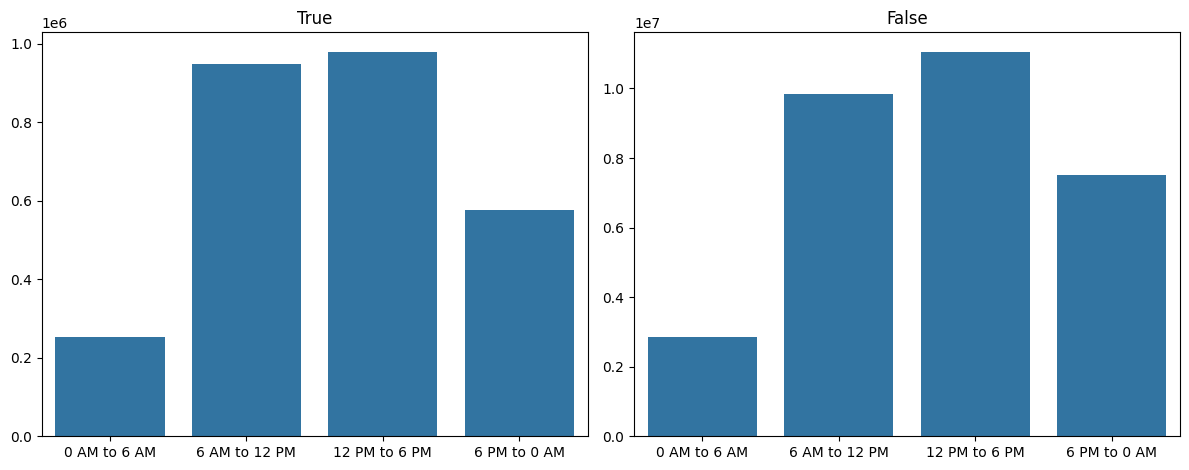

In [252]:
# so search_date is useless too
true_val = original_ds.query('is_booking == 1')
false_val = original_ds.query('is_booking == 0')

t_one , t_two , t_three , t_four = time_sep(true_val , 'search_date')
f_one , f_two , f_three , f_four = time_sep(false_val , 'search_date')

clear_output()

fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

sns.barplot({'0 AM to 6 AM' : len(t_one) , '6 AM to 12 PM' : len(t_two) , '12 PM to 6 PM' : len(t_three) , '6 PM to 0 AM' : len(t_four)} , ax = ax1)
sns.barplot({'0 AM to 6 AM' : len(f_one) , '6 AM to 12 PM' : len(f_two) , '12 PM to 6 PM' : len(f_three) , '6 PM to 0 AM' : len(f_four)} , ax = ax2)

fig.set_figwidth(12)
ax1.set_title('True')
ax2.set_title('False')

plt.tight_layout()
plt.show()

lets check `channel`. we need to find the outliers in this column so we'll plot a boxplot for it and it seems `c4` , `c6` , `c7` , `c8` , `c10` are outliers so we'll drop'em. those percentages are percentage of people that booked a hotel in whole dataset devided in channels. if we see a significant jump in a percentage this shows us this channel has good amount of influence in people to book a hotel. but we dont see that jump in channel. we have 20mil rows with `c9` as their channel and after that around 5mil with `c0`. its not that bad so i dont see any reason to drop this column and any reason to keep yet. maybe we'll get better insight in future so we'll keep it

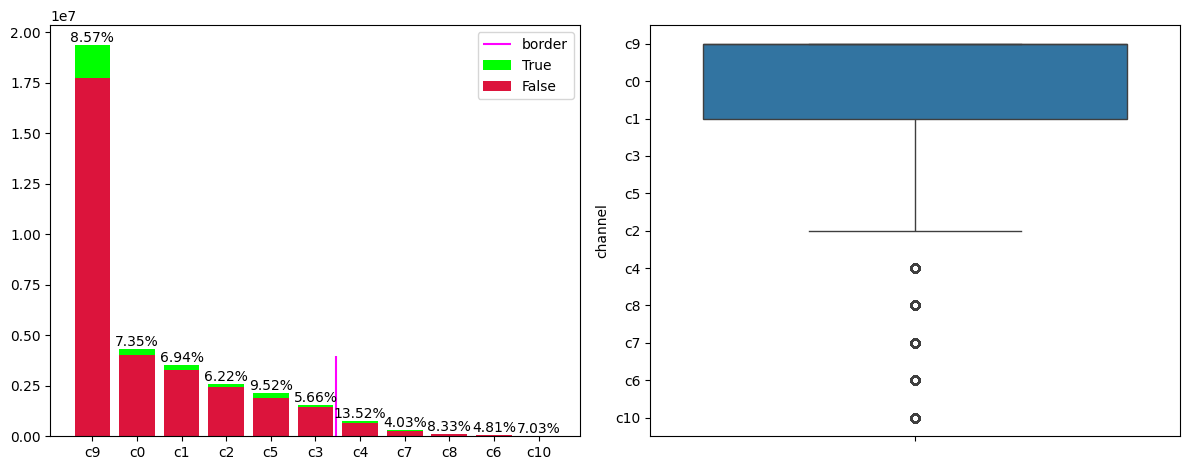

In [303]:
# and we'll consider c4 c8 c7 c6 c10 as outliers
channel_count = original_ds.channel.value_counts()
grouped_channel = original_ds[['channel' , 'is_booking']].groupby(by = 'is_booking')
False_from_channel = grouped_channel.value_counts().loc[False]
True_from_channel = grouped_channel.value_counts().loc[True]
percentage_true = round(((True_from_channel / channel_count) * 100).loc[channel_count.index] , 2).astype(str) + '%' # this loc is for making the order correct



fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

plot_out = ax1.bar(x = channel_count.index , height = channel_count.values  , color = 'lime')
ax1.bar(x = False_from_channel.index , height = False_from_channel.values , color = 'crimson')
ax1.vlines(x = 5.45 , ymin = 0 , ymax = 0.4e7 , color = 'magenta')
sns.boxplot(original_ds.channel , ax = ax2)

ax1.legend(labels = ['border' , 'True' , 'False'])
ax1.bar_label(plot_out , percentage_true)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

8.4% of people that didnt check our site with a mobile booked a hotel but only approx 5.9 of people that checked our site with a mobile booked a hotel. again, not a significant jump and again i didnt find any reason to drop nor keep it yet so we'll just keep it for further investigation.

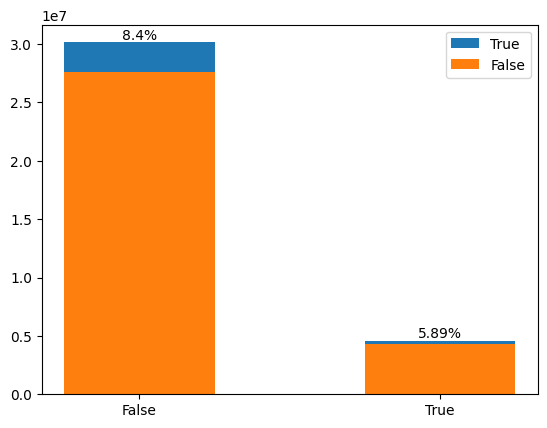

In [302]:
package_counts = original_ds.is_mobile.value_counts()
grouped_mobile = original_ds[['is_booking' , 'is_mobile']].groupby(by = 'is_booking').value_counts()
true_mobile = grouped_mobile.loc[True]
false_package = grouped_mobile.loc[False]
package_percentage = (round((true_mobile / package_counts) * 100 , 2)).astype(str) + '%'

container = plt.bar(x = package_counts.index.astype(str) , height = package_counts.values , width = 0.5)
plt.bar(x = false_package.index , height = false_package.values , width = 0.5)
plt.bar_label(container = container , labels = package_percentage)

plt.legend(['True' , 'False'])
plt.show()

its kinda weird but 9.25% of people that didnt check tour or etc booked a hotel and only 4.52% of people who checked booked a hotel. its about 2 times diff. kinda significant to me. so we'll keep it.

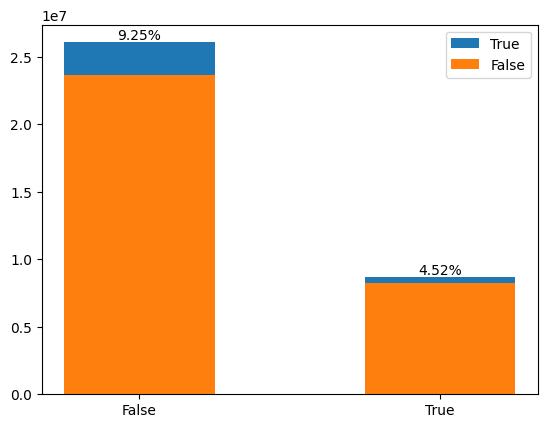

In [301]:
package_counts = original_ds.is_package.value_counts()
grouped_mobile = original_ds[['is_booking' , 'is_package']].groupby(by = 'is_booking').value_counts()
true_package = grouped_mobile.loc[True]
false_package = grouped_mobile.loc[False]
package_percentage = (round((true_package / package_counts) * 100 , 2)).astype(str) + '%'

container = plt.bar(x = package_counts.index.astype(str) , height = package_counts.values , width = 0.5)
plt.bar(x = false_package.index , height = false_package.values , width = 0.5)
plt.bar_label(container = container , labels = package_percentage)

plt.legend(['True' , 'False'])
plt.show()

as we can see from 300 onwards values become similar and kinda same and it important to note that we have approx 50000 unique values in `destination` so it means that from 300 to 50000 we have similar values. i conclude that this column dont give us information we need for training so we'll just drop it

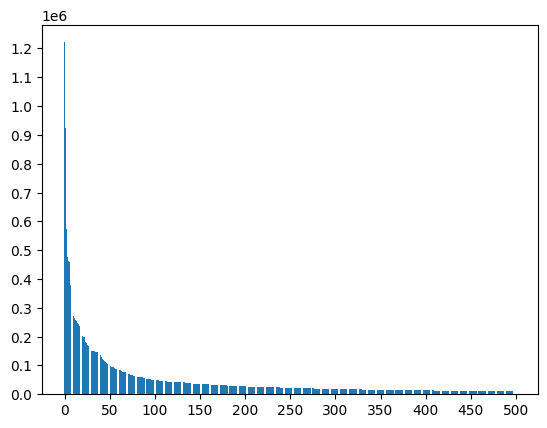

In [8]:
# we can conclude that destination column is useless cuz unique destinations are about 50000
plt.bar(height = original_ds.destination.value_counts().values[:500] , x = range(500))
plt.xticks(range(0,501,50))
plt.yticks(range(0,1250000,100000))
plt.show()

in `n_adults` column boxplot we see what we see so i chose to use z-score as outlier detection instead of boxplot. any values outside of upper bound and lower bound in left plot will be considered an outlier. but i'll drop "0" too despite being inside the bound because it has such a low value. again we see a kinda significant jump in "1" so we'll just keep it for further investigation.

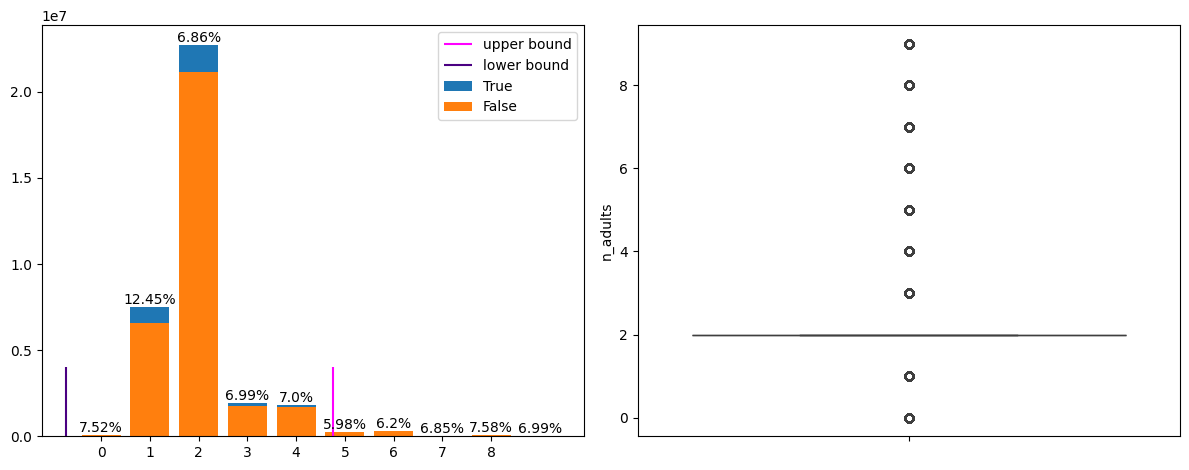

In [249]:
adults_count = original_ds.n_adults.value_counts()
grouped_adults = original_ds[['is_booking' , 'n_adults']].groupby(by = 'is_booking').value_counts()
true_adults = grouped_adults.loc[True]
false_adults = grouped_adults.loc[False]
true_adults_percentage = round(((true_adults / adults_count) * 100).loc[adults_count.index] , 2).astype(str) + '%'
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

container = ax1.bar(x = adults_count.index , height = adults_count.values)
ax1.bar(x = false_adults.index , height = false_adults.values)
ax1.vlines(x = 4.75 , ymin = 0 , ymax = 0.4e7 , color = 'magenta' )
ax1.vlines(x = -0.71 , ymin = 0 , ymax = 0.4e7 , color = 'indigo' )
ax1.set_xticks(range(0 , 9 ,1))
ax1.bar_label(container = container , labels = true_adults_percentage)
ax1.legend(['upper bound' , 'lower bound' , 'True' , 'False'])

sns.boxplot(original_ds.n_adults , ax = ax2)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [15]:
# this is even better than n_children cuz it has more spread so we'll keep 1 2 3 4
print('std: ' , original_ds.n_adults.std())
print('mean: ' , original_ds.n_adults.mean())
print('z-score uppper bound: ', original_ds.n_adults.mean() + (3 * original_ds.n_adults.std()))
print('z-score lower bound: ', original_ds.n_adults.mean() - (3 * original_ds.n_adults.std()))
adults_count

std:  0.9104359454802032
mean:  2.0207137701938307
z-score higher bound:  4.7520216066344405
z-score lower bound:  -0.7105940662467791


n_adults
2    22735597
1     7500149
3     1910852
4     1827973
6      307180
5      259817
8       79353
0       67104
7       40861
9       14089
Name: count, dtype: int64

just like `n_adults` we'll use z-score. but we dont see a significant jump so we dont any reason to drop it so we'll keep it for further investigation

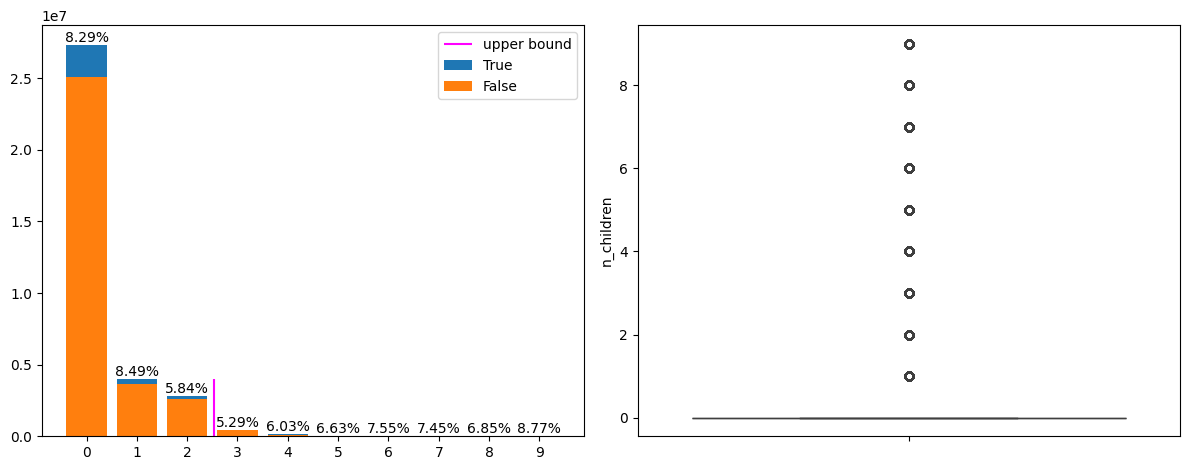

In [237]:
kids_count = original_ds.n_children.value_counts()
grouped_kids = original_ds[['is_booking' , 'n_children']].groupby(by = 'is_booking').value_counts()
true_kids = grouped_kids.loc[True]
false_kids = grouped_kids.loc[False]
true_kids_percentage = round(((true_kids / kids_count) * 100).loc[kids_count.index] , 2).astype(str) + '%'
fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

container = ax1.bar(x = kids_count.index , height = kids_count.values)
ax1.bar(x = false_kids.index , height = false_kids.values)
ax1.vlines(x = 2.53 , ymin = 0 , ymax = 0.4e7 , color = 'magenta' )
ax1.set_xticks(range(0 , 10 ,1))
ax1.bar_label(container = container , labels = true_kids_percentage)
ax1.legend(['upper bound' , 'True' , 'False'])

sns.boxplot(original_ds.n_children , ax = ax2)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [13]:
# this column will be candidate for drop but its not that bad ill keep it and ill build another model without it to see the diff it makes
# we'll keep rows with 0 1 2
print('std: ' , original_ds.n_children.std())
print('mean: ' , original_ds.n_children.mean())
print('z-score upper bound: ', original_ds.n_children.mean() + (3 * original_ds.n_children.std()))
print('z-score lower bound: ', original_ds.n_children.mean() - (3 * original_ds.n_children.std()))
kids_count

std:  0.7320179525485213
mean:  0.3352208324128835
z-score higher bound:  2.5312746900584475
z-score lower bound:  -1.8608330252326803


n_children
0    27343218
1     4001999
2     2780182
3      452528
4      127924
5       17328
6       14182
7        2550
8        2232
9         832
Name: count, dtype: int64

again, we use z-score and we see a 27.73% percent in 0 values which is inside our range! but no its number of occurrence is so insignificant that we'll have to drop that too. and we dont see any jump beside that so we'll it keep it for further investigation

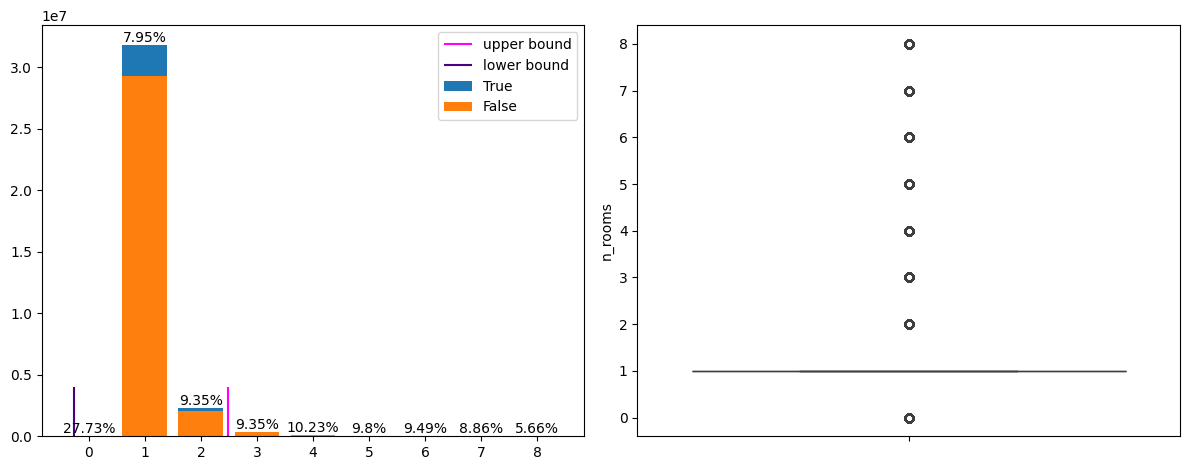

In [221]:
rooms_count = original_ds.n_rooms.value_counts()
grouped_rooms = original_ds[['is_booking' , 'n_rooms']].groupby(by = 'is_booking').value_counts()
true_rooms = grouped_rooms.loc[True]
false_rooms = grouped_rooms.loc[False]
true_rooms_percentage = round(((true_rooms / rooms_count) * 100).loc[rooms_count.index] , 2).astype(str) + '%'

fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

container = ax1.bar(x = rooms_count.index , height = rooms_count.values)
ax1.bar(x = false_rooms.index , height = false_rooms.values)
ax1.vlines(x = 2.49 , ymin = 0 , ymax = 0.4e7 , color = 'magenta' )
ax1.vlines(x = -0.26 , ymin = 0 , ymax = 0.4e7 , color = 'indigo' )
ax1.set_xticks(range(0 , 9 ,1))
ax1.bar_label(container = container , labels = true_rooms_percentage)
ax1.legend(['upper bound' , 'lower bound' , 'True' , 'False'])

sns.boxplot(original_ds.n_rooms , ax = ax2)

fig.set_figwidth(12)
plt.tight_layout()
plt.show()

In [11]:
# we conclude that this info is useless
# with z score method for outlier detection we can use 0 1 2 and delete the rest but with 31 mil "1" and 2mil "2" and 815 "0"
# we see that if these numbers dont complicate things for model to learn, it very unbalanced and doesnt add anything
print('std: ' , original_ds.n_rooms.std())
print('mean: ' , original_ds.n_rooms.mean())
print('z-score upper bound: ', original_ds.n_rooms.mean() + 3 * original_ds.n_rooms.std())
print('z-score lower bound: ', original_ds.n_rooms.mean() - 3 * original_ds.n_rooms.std())
rooms_count

std:  0.45941471763654357
mean:  1.113033037614079
z-score higher bound:  2.49127719052371
z-score lower bound:  -0.26521111529555186


n_rooms
1    31841899
2     2309526
3      387617
4       98719
5       43019
8       28220
6       21574
7       11586
0         815
Name: count, dtype: int64

this plot doesnt give us any useful information. so i dont see any reason to drop or keep it so ill keep it for further investigation

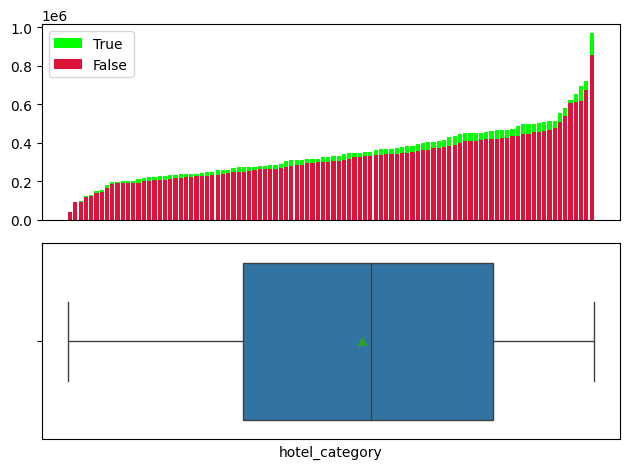

In [158]:
hotel_cat_groupby_booking = original_ds.groupby(by = 'is_booking')['hotel_category'].value_counts()
hotel_cat_counts = original_ds.hotel_category.value_counts().values
labels = original_ds.hotel_category.value_counts().index
F_hotel_cat = hotel_cat_groupby_booking.loc[False].values
T_hotel_cat = hotel_cat_groupby_booking.loc[True].values

F_hotel_cat.sort()
T_hotel_cat.sort()
hotel_cat_counts.sort()


fig , [ax1 , ax2] = plt.subplots(nrows = 2 , ncols = 1)

ax1.bar(height = hotel_cat_counts , x = labels , linewidth = 0 , color = 'lime')
ax1.bar(height = F_hotel_cat , x = labels , linewidth = 0 , color = 'crimson')
ax1.tick_params(bottom = False , labelbottom = False)
ax1.legend(['True' , 'False'])

# the boxplot is for whole data
sns.boxplot(x = original_ds.hotel_category , vert = False , showmeans = True , ax = ax2)
ax2.tick_params(bottom = False , labelbottom = False)
ax2.invert_xaxis()

fig.tight_layout()
plt.show()

with IQR we'll find outliers in our new column

In [36]:
valid_diff_date = original_ds.query('diff_date > 0')['diff_date']
upper_cap = valid_diff_date.quantile(.75) + (1.5 * (valid_diff_date.quantile(.75) - (valid_diff_date.quantile(.25))))
print("diff_date upper cap: " , upper_cap)
print('any value bigger than this is a outlier')

diff_date upper cap:  8.5
any value bigger than this is a outlier


and we can see people tend to stay in hotels for couple of days the more we increase days less people will book a hotel. plot look promising we'll keep it

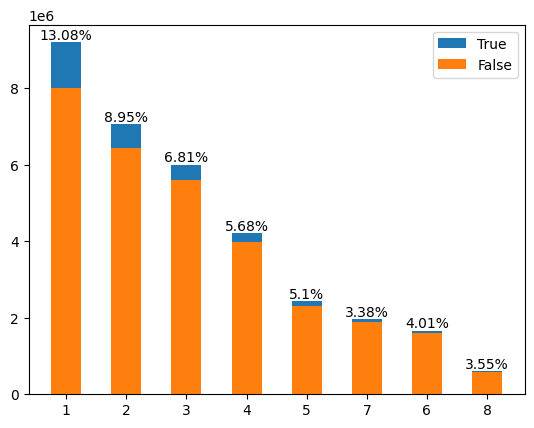

In [356]:
outlier_free_diff_date = original_ds.query('0 < diff_date < 8.5')['diff_date'].value_counts()
grouped_outlier_free_diff_date = original_ds.query('0 < diff_date < 8.5')[['diff_date' , 'is_booking']].groupby(by = 'is_booking').value_counts()
true_diff_date = grouped_outlier_free_diff_date.loc[True]
false_diff_date = grouped_outlier_free_diff_date.loc[False]
diff_date_percentage = round(((true_diff_date / outlier_free_diff_date) * 100).loc[outlier_free_diff_date.index] , 2).astype(str) + '%' 

container = plt.bar(x = outlier_free_diff_date.index.astype(str) , height = outlier_free_diff_date.values , width = 0.5)
plt.bar(x = false_diff_date.index.astype(str) , height = false_diff_date.values , width = 0.5)
plt.bar_label(container = container , labels = diff_date_percentage)

plt.legend(['True' , 'False'])
plt.show()

and now we'll drop our useless columns and outliers. and turn our categorical values into something that computer understands and turn their dtype into `int8` so it occupies less space

In [6]:
# now ew pop useless columns
dropped_ds = original_ds.drop(['user' , 'search_date' , 'destination' , 'checkIn_date' , 'checkOut_date' , 'n_rooms'] , axis = 1)


# negative value for diff_date is unreasonable and i checked their site you cant search for a hotel where checkIn and checkOut is the same date
# so diff_value must be higher than 0
cleaned_ds = dropped_ds.query('channel not in ["c4" , "c8" , "c7" , "c6" , "c10"] & n_children in [0 , 1 , 2] & n_adults in [1 , 2 , 3 , 4] & 0 < diff_date < 8.5')

In [8]:
# now we make True False to 1 0
cleaned_ds['is_mobile'] = bool_to_binary(ds = cleaned_ds , column = 'is_mobile')
cleaned_ds['is_package'] = bool_to_binary(ds = cleaned_ds , column = 'is_package')
cleaned_ds['is_booking'] = bool_to_binary(ds = cleaned_ds , column = 'is_booking')
clear_output()

In [9]:
cleaned_ds['channel'] = cleaned_ds['channel'].str[1:].astype('Int8')
cleaned_ds['hotel_category'] = cleaned_ds['hotel_category'].str[1:].astype('Int8')
cleaned_ds['n_adults'] = cleaned_ds['n_adults'].astype('Int8')
cleaned_ds['n_children'] = cleaned_ds['n_children'].astype('Int8')
cleaned_ds['diff_date'] = cleaned_ds['diff_date'].astype('Int8')
clear_output()

In [2]:
# with open('cleaned_ds.pkl' , 'wb') as pickle_out:
#     pickle.dump(cleaned_ds , pickle_out)
#     pickle_out.close()

with open('cleaned_ds.pkl' , 'rb') as pickle_in:
    cleaned_ds = pickle.load(pickle_in)
    pickle_in.close()

In [3]:
cleaned_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30725432 entries, 0 to 34742974
Data columns (total 8 columns):
 #   Column          Dtype
---  ------          -----
 0   channel         Int8 
 1   is_mobile       int8 
 2   is_package      int8 
 3   n_adults        Int8 
 4   n_children      Int8 
 5   hotel_category  Int8 
 6   is_booking      int8 
 7   diff_date       Int8 
dtypes: Int8(5), int8(3)
memory usage: 615.3 MB


as we can see in `is_mobile` , `is_package` , `n_children` and `is_booking` 75% of our values are "0" and this tell us these columns dont give us much info for training but `is_booking` is our target! we cant drop that so we have to find some way to fix this. one way is repeat some rows and concatenate it to our dataframe so we achieve a more balanced dataframe f.e if we have 100 datapoints which we have 10 zeros and 90 ones so we repeat 0 as much as we get 80 zeros out of it and after we concatenate it we have 90 ones and 90 zeros. our approx ratio is 90% false and 10 % true for our target column so we need to repeat rows with true value as their `is_booking` column. but we can fix `is_mobile` , `is_package` , `n_children` too. we can repeat "1" for `is_mobile` and `is_package` and ("0" , "1") for `n_children`. so we need to repeat rows with "1" as their `is_mobile` and `is_package` columns and ("0" , "1") as their `n_children` column and "1" as our target column at the same time

In [4]:
cleaned_ds.describe()

,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
count,30725432.0,3.072543e+07,3.072543e+07,30725432.0,30725432.0,30725432.0,3.072543e+07,30725432.0
mean,5.932372,1.333024e-01,2.354903e-01,1.939424,0.279726,49.724946,8.331193e-02,2.980108
std,3.769768,3.399013e-01,4.243049e-01,0.698897,0.603668,28.97532,2.763531e-01,1.896012
min,0.0,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.000000e+00,1.0
25%,2.0,0.000000e+00,0.000000e+00,2.0,0.0,25.0,0.000000e+00,1.0
50%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,49.0,0.000000e+00,3.0
75%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,73.0,0.000000e+00,4.0
max,9.0,1.000000e+00,1.000000e+00,4.0,2.0,99.0,1.000000e+00,8.0


In [5]:
correlations = cleaned_ds.corr()
correlations

,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
channel,1.000000,-0.033837,-0.011388,-0.035926,0.006869,0.000031,0.027926,-0.020789
is_mobile,-0.033837,1.000000,0.056877,0.033923,0.020096,0.008863,-0.031424,0.022629
is_package,-0.011388,0.056877,1.000000,0.005486,-0.033318,0.037593,-0.073408,0.389145
n_adults,-0.035926,0.033923,0.005486,1.000000,0.091287,0.015617,-0.061254,0.051342
n_children,0.006869,0.020096,-0.033318,0.091287,1.000000,0.012787,-0.020051,0.049748
hotel_category,0.000031,0.008863,0.037593,0.015617,0.012787,1.000000,-0.021307,0.053591
is_booking,0.027926,-0.031424,-0.073408,-0.061254,-0.020051,-0.021307,1.000000,-0.112400
diff_date,-0.020789,0.022629,0.389145,0.051342,0.049748,0.053591,-0.112400,1.000000


and these correlations are so disappointing and if we train on this we abslutely get nothing good

<Axes: >

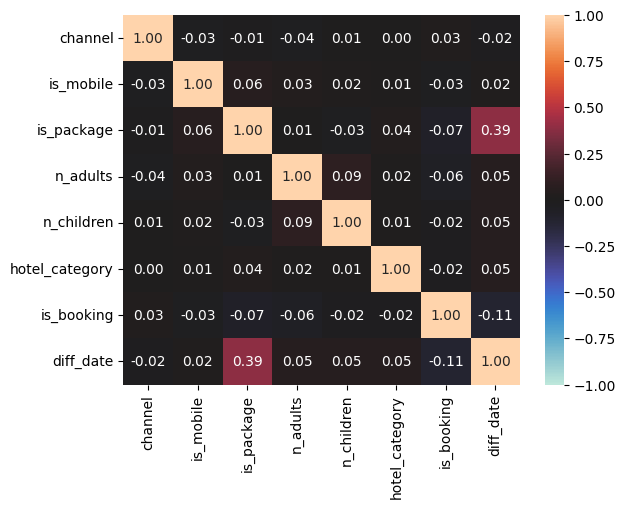

In [6]:
sns.heatmap(correlations , annot = True , vmin = -1 , fmt = ".2f" , center = 0)

so we'll get our rows with mentioned values to repeat'em

In [7]:
specific_rows = cleaned_ds.query('is_mobile == 1 and is_package == 1 and is_booking == 1 and (n_children == 1 or n_children == 2)')
print(specific_rows.n_children.value_counts())

n_children
1    2719
2    1799
Name: count, dtype: Int64


we know that n_children has 2 possible values (1 , 2). and they and diff values ('2' have less quantity than '1') so if we resample them they will have different impact so we need to make them have an equal impact. at first we separate all rows with n_chilren = 1 and all rows with n_chilren = 2. we resample 2 that have same imapct as 1 does and we concatenate resampled rows with rows with n_children == 1. after these steps we resample the obtained dataframe with our cleaned_ds so we can have a more balanced dataset

In [8]:
major_E = specific_rows.query('n_children == 1')
minor_E = specific_rows.query('n_children == 2')

resampled_minority = resample(minor_E , replace = True , n_samples = len(major_E))
better_specific_rows = pd.concat([major_E , resampled_minority])

resampled_rows = resample(better_specific_rows , replace = True , n_samples = int(24e6))
better_ds = pd.concat([cleaned_ds , resampled_rows])

In [9]:
print(cleaned_ds.is_booking.value_counts() , '\n')
print(better_ds.is_booking.value_counts())

is_booking
0    28165637
1     2559795
Name: count, dtype: int64 

is_booking
0    28165637
1    26559795
Name: count, dtype: int64


In [10]:
print(cleaned_ds.is_mobile.value_counts() , '\n')
print(better_ds.is_mobile.value_counts())

is_mobile
0    26629657
1     4095775
Name: count, dtype: int64 

is_mobile
1    28095775
0    26629657
Name: count, dtype: int64


In [11]:
print(cleaned_ds.is_package.value_counts() , '\n')
print(better_ds.is_package.value_counts())

is_package
0    23489890
1     7235542
Name: count, dtype: int64 

is_package
1    31235542
0    23489890
Name: count, dtype: int64


In [12]:
print(cleaned_ds.n_children.value_counts() , '\n')
print(better_ds.n_children.value_counts())

n_children
0    24633861
1     3588433
2     2503138
Name: count, dtype: Int64 

n_children
0    24633861
1    15588492
2    14503079
Name: count, dtype: Int64


In [13]:
display(cleaned_ds.describe())
display(better_ds.describe())

,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
count,30725432.0,3.072543e+07,3.072543e+07,30725432.0,30725432.0,30725432.0,3.072543e+07,30725432.0
mean,5.932372,1.333024e-01,2.354903e-01,1.939424,0.279726,49.724946,8.331193e-02,2.980108
std,3.769768,3.399013e-01,4.243049e-01,0.698897,0.603668,28.97532,2.763531e-01,1.896012
min,0.0,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.000000e+00,1.0
25%,2.0,0.000000e+00,0.000000e+00,2.0,0.0,25.0,0.000000e+00,1.0
50%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,49.0,0.000000e+00,3.0
75%,9.0,0.000000e+00,0.000000e+00,2.0,0.0,73.0,0.000000e+00,4.0
max,9.0,1.000000e+00,1.000000e+00,4.0,2.0,99.0,1.000000e+00,8.0


,channel,is_mobile,is_package,n_adults,n_children,hotel_category,is_booking,diff_date
count,54725432.0,5.472543e+07,5.472543e+07,54725432.0,54725432.0,54725432.0,5.472543e+07,54725432.0
mean,5.876699,5.133952e-01,5.707683e-01,1.959631,0.81488,51.235064,4.853282e-01,3.713775
std,3.889699,4.998205e-01,4.949665e-01,0.664897,0.825155,28.972972,4.997847e-01,2.008677
min,0.0,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.000000e+00,1.0
25%,1.0,0.000000e+00,0.000000e+00,2.0,0.0,26.0,0.000000e+00,2.0
50%,9.0,1.000000e+00,1.000000e+00,2.0,1.0,53.0,0.000000e+00,3.0
75%,9.0,1.000000e+00,1.000000e+00,2.0,2.0,73.0,1.000000e+00,5.0
max,9.0,1.000000e+00,1.000000e+00,4.0,2.0,99.0,1.000000e+00,8.0


as we can see correlations changed. new plot give us some insight to drop some of our columns. its safe to say if we have correlation bigger than 0.6 or lower than -0.6 we have good correlation (geeksforgeeks) so its bad when our non-target columns have good correlation with each other because it doesnt give us new information for predicting target but its good if our non-target columns have good correlation with target column. so if we check new correlations we see is_mobile , is_package have good correlation with each other while they are non-target so we need to keep only one of them. hotel_category and channel and n_adults columns dont have good correlation with any columns so we drop them too.

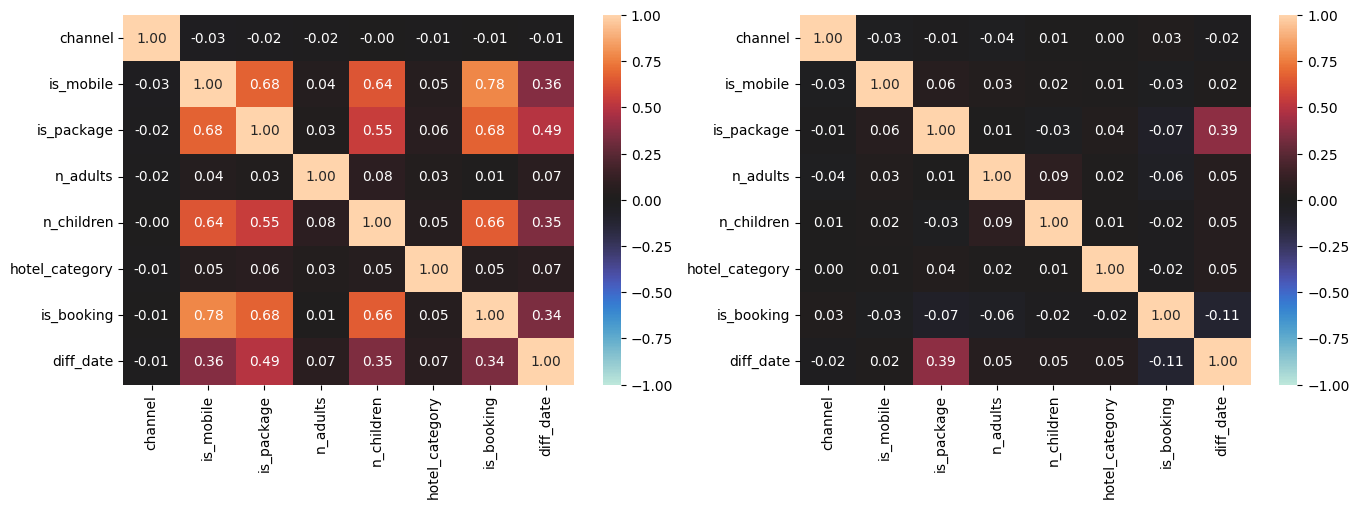

In [14]:
better_correlation = better_ds.corr()

fig , [ax1 , ax2] = plt.subplots(ncols = 2 , nrows = 1)

sns.heatmap(better_correlation , annot = True , vmin = -1 , fmt = ".2f" , center = 0 , ax = ax1)
sns.heatmap(correlations , annot = True , vmin = -1 , fmt = ".2f" , center = 0 , ax = ax2)

fig.set_figwidth(16)
plt.show()

In [15]:
df = better_ds.drop(['hotel_category' , 'channel' , 'n_adults' , 'is_package'] , axis = 1)

i dont get what this plot says

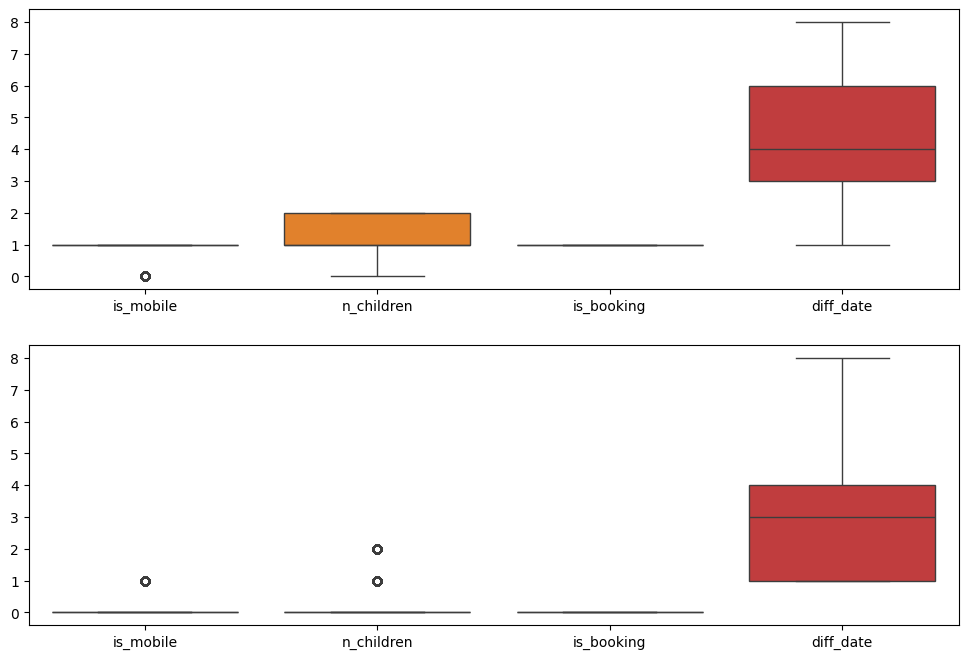

In [17]:
fig , [ax1 , ax2] = plt.subplots(nrows = 2 , ncols=1)
sns.boxplot(df.query('is_booking == 1') , ax = ax1)
sns.boxplot(df.query('is_booking == 0') , ax = ax2)

fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

<Axes: >

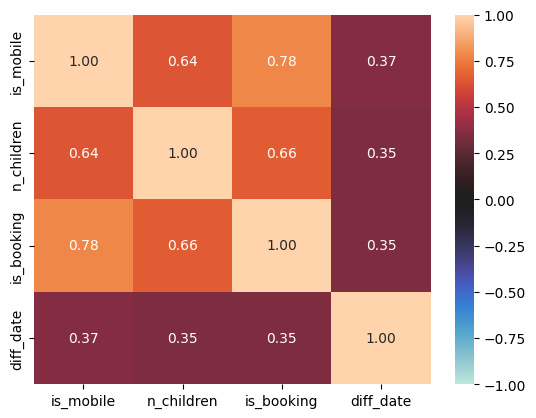

In [19]:
sns.heatmap(df.corr() , annot = True , vmin = -1 , fmt = ".2f" , center = 0)

In [20]:
df.describe()

,is_mobile,n_children,is_booking,diff_date
count,5.472543e+07,54725432.0,5.472543e+07,54725432.0
mean,5.133952e-01,0.814863,4.853282e-01,3.718346
std,4.998205e-01,0.825141,4.997847e-01,2.011267
min,0.000000e+00,0.0,0.000000e+00,1.0
25%,0.000000e+00,0.0,0.000000e+00,2.0
50%,1.000000e+00,1.0,0.000000e+00,3.0
75%,1.000000e+00,2.0,1.000000e+00,5.0
max,1.000000e+00,2.0,1.000000e+00,8.0


In [3]:
# with open('df.pkl' , 'wb') as pickle_out:
#     pickle.dump(df , pickle_out)
#     pickle_out.close()

with open('df.pkl' , 'rb') as pickle_in:
    df = pickle.load(pickle_in)
    pickle_in.close()

we'll split the data into train test validation

In [4]:
X = df.drop(['is_booking'] , axis = 1)
y = df['is_booking']

x_train , x_test , y_train , y_test = train_test_split(X , y , test_size = 0.1 , shuffle = True)
x_train , x_val , y_train , y_val = train_test_split(x_train , y_train , test_size = 0.1 , shuffle = True)

x_train = np.asarray(x_train , dtype = 'float32') # we'll turn'em into float32 cuz our model only works with this kind of dtype
y_train = np.asarray(y_train , dtype = 'float32')

x_test = np.asarray(x_test , dtype = 'float32')
y_test = np.asarray(y_test , dtype = 'float32')

x_val = np.asarray(x_val , dtype = 'float32')
y_val = np.asarray(y_val , dtype = 'float32')

# Training
***
## Neural network and it's results

In [5]:
model = keras.Sequential([
    keras.layers.Dense(300 , activation = 'elu' , kernel_initializer = 'he_normal' , input_shape = (3,)),
    keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal'),
    keras.layers.Dense(200 , activation = 'elu' , kernel_initializer = 'he_normal'),
    # keras.layers.Dense(300 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.6)),
    # keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.35)),
    # keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.35)),
    # keras.layers.Dense(200 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.5)),
    # keras.layers.Dense(300 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.6)),
    keras.layers.Dense(100 , activation = 'elu' , kernel_initializer = 'he_normal' , kernel_constraint = keras.constraints.max_norm(0.6)),
    keras.layers.Dense(1 , activation = 'sigmoid'),
])
model.compile(loss = 'binary_crossentropy' , optimizer = keras.optimizers.Adam(learning_rate = 0.0001) , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               1200      
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 200)               20200     
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 71,701
Trainable params: 71,701
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(x_train , y_train , validation_data = (x_val , y_val) , batch_size = 1024 , epochs = 6)

Epoch 1/6
43289/43289 [==============================] - 166s 4ms/step - loss: 0.2128 - accuracy: 0.9391 - val_loss: 0.2127 - val_accuracy: 0.9391
Epoch 2/6
43289/43289 [==============================] - 162s 4ms/step - loss: 0.2128 - accuracy: 0.9391 - val_loss: 0.2126 - val_accuracy: 0.9391
Epoch 3/6
43289/43289 [==============================] - 162s 4ms/step - loss: 0.2127 - accuracy: 0.9391 - val_loss: 0.2126 - val_accuracy: 0.9391
Epoch 4/6
43289/43289 [==============================] - 164s 4ms/step - loss: 0.2127 - accuracy: 0.9390 - val_loss: 0.2126 - val_accuracy: 0.9391
Epoch 5/6
43289/43289 [==============================] - 162s 4ms/step - loss: 0.2127 - accuracy: 0.9391 - val_loss: 0.2125 - val_accuracy: 0.9391
Epoch 6/6
43289/43289 [==============================] - 159s 4ms/step - loss: 0.2127 - accuracy: 0.9391 - val_loss: 0.2127 - val_accuracy: 0.9391


In [2]:
# model.save('model.h5')
model = keras.models.load_model('model.h5')

<Axes: >

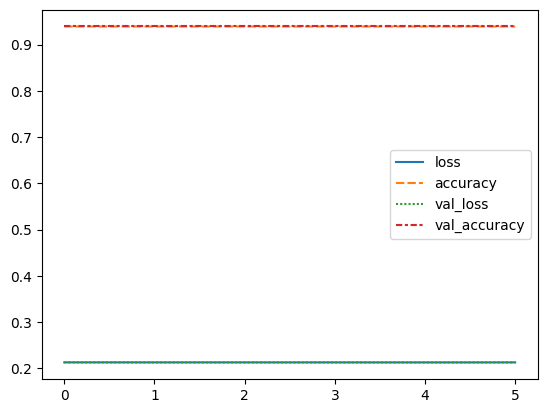

In [11]:
sns.lineplot(history.history)

In [6]:
prediction = model.predict(x_test[ :250000])

7813/7813 [==============================] - 9s 1ms/step


In [8]:
print(f'roc auc score: {roc_auc_score(y_test[ :250000] , prediction)}')

roc auc score: 0.9554103157614475


In [9]:
r2 = r2_score(y_test[ :250000] , prediction)
Adj_r2 =  1 - (1 - r2) * (5242 - 1) / (5242 - 100 - 1)
print(f'r2 = {r2}  ///  adj_r2 = {Adj_r2}')

r2 = 0.779150128364563  ///  adj_r2 = 0.774854274024251


In [10]:
prediction_2 = np.where(prediction >= 0.5 , 1 , 0)

print(f'f1_score: {f1_score(y_test[ :250000] , prediction_2)}' , '\n')
print('confusion maxtrix:')
print(confusion_matrix(y_test[ :250000] , prediction_2) , '\n')
print(f'accuracy_score: {accuracy_score(y_test[ :250000] , prediction_2)}')

f1_score: 0.9348740842001837 

confusion maxtrix:
[[125335   3779]
 [ 11466 109420]] 

accuracy_score: 0.93902


## Knn and it's results
***

In [8]:
knn_model = KNeighborsClassifier(n_neighbors = 7 , weights = 'distance' , n_jobs = -1)
knn_model.fit(x_train , y_train )

In [11]:
knn_prediction = knn_model.predict(x_test[ :2500])
knn_prediction_2 = np.where(knn_prediction >= 0.5 , 1 , 0)

print(f'f1_score: {f1_score(y_test[ :2500] , knn_prediction_2)}' , '\n')
print('confusion maxtrix:')
print(confusion_matrix(y_test[ :2500] , knn_prediction_2) , '\n')
print(f'accuracy_score: {accuracy_score(y_test[ :2500] , knn_prediction_2)}')

f1_score:0.925893635571055 

confusion maxtrix:
[[1268   21]
 [ 149 1062]] 

accuracy_score:0.932


## Logistic regression and it's results
***

In [34]:
Lreg = LogisticRegression(n_jobs = -1)
Lreg_model = Lreg.fit(x_train , y_train)

In [36]:
Lreg_prediction = Lreg_model.predict(x_test[ :2500])
Lreg_prediction_2 = np.where(Lreg_prediction >= 0.5 , 1 , 0)

print(f'f1_score: {f1_score(y_test[ :2500] , Lreg_prediction_2)}' , '\n')
print('confusion maxtrix:')
print(confusion_matrix(y_test[ :2500] , Lreg_prediction_2) , '\n')
print(f'accuracy_score: {accuracy_score(y_test[ :2500] , Lreg_prediction_2)}')

f1_score: 0.8930088837388953 

confusion maxtrix:
[[1067  171]
 [ 106 1156]] 

accuracy_score: 0.8892


## Decision tree and it's results
***

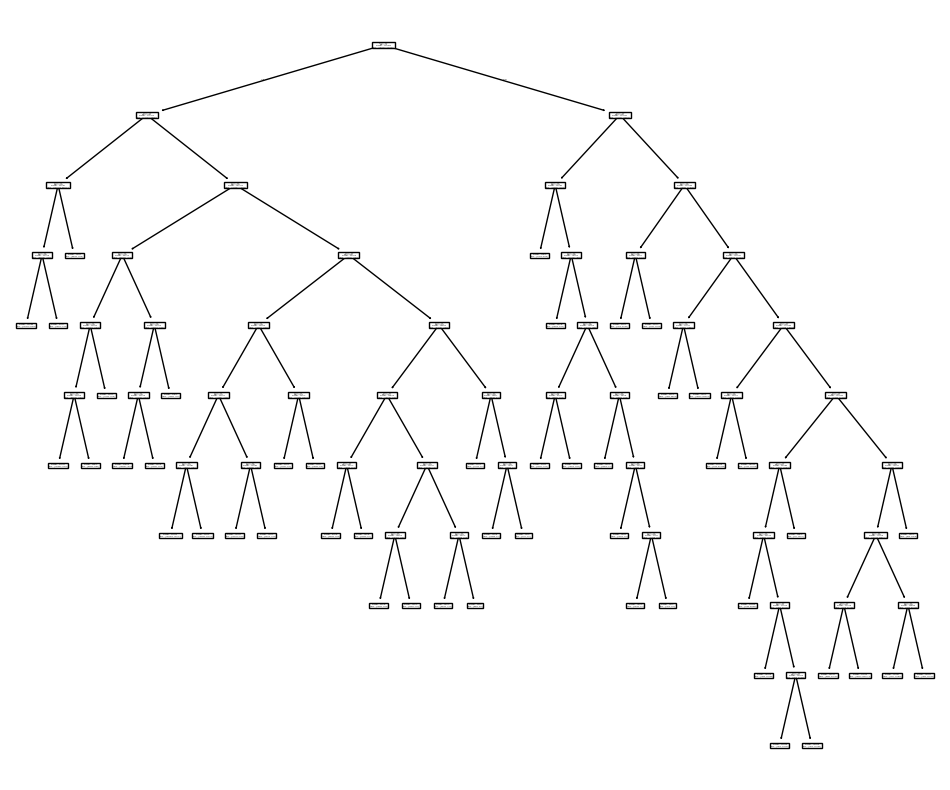

In [51]:
DT = DecisionTreeClassifier()
DT_model = DT.fit(x_train , y_train)

fig , ax = plt.subplots(ncols=1 , nrows=1)
plot_tree(DT_model , ax = ax)
fig.set_figwidth(12)
fig.set_figheight(10)
plt.show()

In [41]:
DT_prediction = DT_model.predict(x_test[ :2500])
DT_prediction_2 = np.where(DT_prediction >= 0.5 , 1 , 0)

print(f'f1_score: {f1_score(y_test[ :2500] , DT_prediction_2)}' , '\n')
print('confusion maxtrix:')
print(confusion_matrix(y_test[ :2500] , DT_prediction_2) , '\n')
print(f'accuracy_score: {accuracy_score(y_test[ :2500] , DT_prediction_2)}')

f1_score: 0.9364303178484108 

confusion maxtrix:
[[1195   43]
 [ 113 1149]] 

accuracy_score: 0.9376


## SVM and it's results
***

In [7]:
svm = LinearSVC()
svm_model = svm.fit(x_train , y_train)

In [6]:
svm_prediction = svm_model.predict(x_test[ :2500])
svm_prediction_2 = np.where(svm_prediction >= 0.5 , 1 , 0)

print(f'f1_score: {f1_score(y_test[ :2500] , svm_prediction_2)}' , '\n')
print('confusion maxtrix:')
print(confusion_matrix(y_test[ :2500] , svm_prediction_2) , '\n')
print(f'accuracy_score: {accuracy_score(y_test[ :2500] , svm_prediction_2)}')

f1_score: 0.8879344006247559 

confusion maxtrix:
[[1076  186]
 [ 101 1137]] 

accuracy_score: 0.8852


# results
***

here are accuracy scores for our 5 models we investigated:
* `MLP` : 0.93902
* `Knn` : 0.932
* `Logistic regression` : 0.8892
* `Decision tree` : 0.9376
* `SVM` : 0.8852

so we can conclude that MLP is our chosen model